
# Exercise 1: Labor supply without capital

Recall the consumption & labor choice problem studied in the lecture. 
In this exercise, we revisit this setting but assume that there is 
no capital in the economy.

## Household problem

Households choose $c$ and $h$ to maximize utility
$$
u(c,h) = \frac{c^{1-\gamma} - 1}{1-\gamma} - \psi \frac{h^{1+1/\theta}}{1+1/\theta}
$$
subject to the budget constraint
$$
c = w \cdot h + \pi
$$
where $\pi$ are firm profits which are distributed to all households equally.
Since all households are identical, we assume that the economy is populated by a *single* representative household.

## Firm problem

We assume that firms have the decreasing-returns-to-scale production function
$$
Y = z L^{1-\alpha}
$$
where $z$ is productivity (TFP) and labor $L$ is the only input factor.
Firms maximize profits $\Pi$,
$$
\max_L \Pi = zL^{1-\alpha} - wL
$$
which gives rise to the first-order condition
$$
\frac{\partial \Pi}{\partial L} = 
(1-\alpha) z L^{-\alpha} - w = 0
$$
We can solve for $L$ to obtain the firm's optimal labor demand for given $w$:
<a id='ex1-labor-demand'></a>
$$
\tag{1.1}
L = \left(\frac{(1-\alpha) z}{w}\right)^{\frac{1}{\alpha}}
$$
For simplicity, we assume there is a *single* firm which takes wages
and the price of output as given, where the latter is normalized to one.

## Equilibrium

The general equilibrium in this economy is a set of quantities $(L,Y,\Pi,c,h,\pi)$ and the wage rate $w$ 
which solve the household's and firm's problem, and the following conditions are satisfied:

- Labor market: $L = h$ (hours $h$ supplied by households equal labor $L$ demanded by firms).
- Goods market: $Y = c$ (the amount of goods $c$ consumed by households equals aggregate output).
- Profits: $\Pi = \pi$ (profits distributed by firms equal profits received by households).


## Analytical solution

By combining the household and firm first-order conditions, the 
problem can be reduced to a single equation in a single unknown, $L$ (or $h$):
<a id='ex1-exact-labor'></a>
$$
\tag{1.2}
h = L = \left(\frac{(1-\alpha) z^{1-\gamma}}{\psi} \right)^{\frac{1}{1/\theta + \alpha + \gamma(1-\alpha)}}
$$
We will use this expression later to compare the numerical to this exact solution.

## Numerical solution

In the following, you are asked to adapt the code from the lecture to solve this problem.
You should use the template file [`workshop06_ex1.py`](`workshop06_ex1.py`)
provided for this exercise to implement your solution.

1. Adapt the `Parameters` data class 

    ```python
    @dataclass
    class Parameters:
        pass
    ```

    so that it contains the following parameters as attributes:
    $\alpha = 0.36$, $z = 1$, $\gamma = 2$, $\psi = 1$, $\theta = 0.5$.

2. Write the function `solve_hh(w, pi, par)` to solve the household problem
   for a given $w$ and $\pi$. This function should return the household
   choices, in particular the **labor supply $h$**.

   Use the utility function `util(c, h, par)` defined in the template file 
   for this purpose (this is the same function we used in the lecture).

3. Write the function `solve_firm(w, par)` which returns the firm's **labor
    demand $L$** given by [(1.1)](#ex1-labor-demand), 
    output $Y$, and profits $\Pi$ for a given wage $w$.

4. Write the function `compute_labor_ex_demand(w, par)` which returns
   the **excess labor demand** for a given wage $w$.

5. Write the function `compute_equilibrium(par)` which uses a root-finder 
    to locate the equilibrium, computes the equilibrium
    quantities $(L,Y,\Pi,c,h,\pi)$ and prices $(w, r)$ and stores these
    using an instance of the `Equilibrium` data class defined in
    [`workshop06_ex1.py`](workshop06_ex1.py).

6.  Compute the equilibrium using the function you just implemented 
    and print the quantities and prices using 
    `print_equilibrium()` implemented in [`workshop06_ex1.py`](workshop06_ex1.py)
    (you don't need to write this function yourself).

7.  Compare your numerical solution to the analytical solution for the equilibrium $L$ returned by
    `compute_analytical_solution()` implemented in [`workshop06_ex1.py`](workshop06_ex1.py).

*Note:* Include the following cell magic to automatically reload any changes you make to the template file:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dataclasses import dataclass


@dataclass
class Parameters:
    """Container to store the problem's parameters."""

    alpha: float = 0.36  # Capital share in production function
    z: float = 1.0  # TFP
    gamma: float = 2.0  # RRA in utility
    psi: float = 1.0  # Weight on disutility of working
    theta: float = 0.5  # Frisch elasticity of labor supply

In [3]:
from scipy.optimize import minimize

from workshop06_ex1 import util


def solve_hh(w, pi, par: Parameters):
    """
    Solve household problem for given prices and parameters.

    Parameters
    ----------
    w : float
        Wage rate
    pi : float
        Firm profits distributed to households
    par : Parameters
        Parameter instance

    Returns
    -------
    c_opt : float
        Optimal consumption
    h_opt : float
        Optimal labor supply
    """

    # Initial guess for h
    h_guess = 0.5

    res = minimize(
        lambda h: -util(w * h + pi, h, par),
        x0=h_guess,
        method="L-BFGS-B",
        bounds=((0, None),),
    )

    if not res.success:
        # Print diagnostic error message if minimizer had problems
        print("Minimizer did not terminate successfully")
        print(res.message)
        print(f"  Arguments: w={w}, pi={pi}")

    # Store optimal hours choice
    h_opt = res.x[0]
    # Optimal consumption follows from budget constraint
    c_opt = w * h_opt + pi

    return c_opt, h_opt

In [4]:
def solve_firm(w, par: Parameters):
    """
    Compute labor demand and profits implied by firm's first-order condition
    for given prices w.

    Parameters
    ----------
    w : float
        Wage rate
    par : Parameters
        Parameter instance

    Returns
    -------
    L : float
        Labor demand
    Y : float
        Output
    Pi : float
        Profits
    """

    # Labor demand
    L = ((1 - par.alpha) * par.z / w) ** (1 / par.alpha)

    # Output
    Y = par.z * L ** (1 - par.alpha)

    # Profits
    Pi = Y - w * L

    return L, Y, Pi

In [5]:
def compute_labor_ex_demand(w, par: Parameters):
    """
    Compute excess demand for labor.

    Parameters
    ----------
    w : float
        Wage rate
    par : Parameters
        Parameter instance

    Returns
    -------
    ex_demand : float
        Excess demand for labor
    """

    # Wage and profits implied by firm's first-order condition
    L, Y, Pi = solve_firm(w, par)

    # Optimal household choices for given prices
    c_opt, h_opt = solve_hh(w, Pi, par)

    # Excess demand for labor
    ex_demand = L - h_opt  # L should be equal to h_opt in equilibrium

    return ex_demand

In [6]:
@dataclass
class Equilibrium:
    """
    Container to store equilibrium allocations and prices.
    """

    par: Parameters = None
    c: float = None
    h: float = None
    w: float = None
    L: float = None
    Y: float = None
    Pi: float = None

In [7]:
from scipy.optimize import root_scalar


def compute_equilibrium(par):
    """
    Compute the equilibrium for given parameters.

    Parameters
    ----------
    par : Parameters
        Parameter instance

    Returns
    -------
    eq : Equilibrium
        Equilibrium instance containing equilibrium values
    """

    # Define initial bracket for root finder
    bracket = (1.0e-3, 5)

    res = root_scalar(compute_labor_ex_demand, bracket=bracket, args=(par,))

    if not res.converged:
        print("Equilibrium root-finder did not terminated successfully")

    # Create instance of equilibrium class
    eq = Equilibrium(par=par, w=res.root)

    # Equilibrium wage, output and profits
    eq.L, eq.Y, eq.Pi = solve_firm(eq.w, par)

    # Equilibrium household choices
    eq.c, eq.h = solve_hh(eq.w, eq.Pi, par)

    return eq

In [8]:
from workshop06_ex1 import print_equilibrium

# Get instance of default parameter values
par = Parameters()

# Solve for equilibrium
eq = compute_equilibrium(par)

# Print equilibrium quantities and prices
print_equilibrium(eq)

Equilibrium:
  Households:
    c = 0.92453
    h = 0.88461
  Firms:
    Y = 0.92453
    L = 0.88461
    Pi = 0.33283
  Prices:
    w = 0.66888
  Market clearing:
    Labor market: -7.30551e-10
    Goods market: 4.88652e-10


In [11]:
from workshop06_ex1 import compute_analytical_solution

# Compare to analytical solution
L = compute_analytical_solution(par)

In [12]:
print(f"Analytical solution: h = L = {L:.5f}")
print(f"Numerical solution: h = {eq.h:.5f}, L = {eq.L:.5f}")

Analytical solution: h = L = 0.88461
Numerical solution: h = 0.88461, L = 0.88461


***
# Exercise 2: Unequal distribution of profits

We now extend the setting from Exercise 1 and assume that a fraction of households solely live on their labor income (type 1),
while profits are only distributed to a subset of households (type 2). We can think of these households as workers and entrepreneurs, respectively.
We assume the economy is populated by $N_1$ households of type 1 and $N_2$ households of type 2.

## Household problem

All households have identical preferences which are unchanged from the previous exercise, but their budget constraints differ. For type-1 households, it is given by 
$$
c_1 = w \cdot h_1
$$
whereas for type-2 households it's
$$
c_2 = w \cdot h_2 + \pi_2
$$
The subscripts in $c_1$, $c_2$, $h_1$, $h_2$, and $\pi_2$ index the household type since different households will
choose different levels of consumption and labor supply.

## Firm problem

The firm problem remains unchanged from the previous exercise. For convenience, we repeat the central equations:
$$
\begin{aligned}
\text{Labor demand: } && L &= \left(\frac{(1-\alpha) z}{w}\right)^{\frac{1}{\alpha}}  \\
\text{Output: } && Y &= z L^{1-\alpha}  \\
\text{Profits: } && \Pi &= zL^{1-\alpha} - wL 
\end{aligned}
$$


## Equilibrium

The general equilibrium in this economy is a set of quantities $(L,Y,\Pi,c_1,c_2,h_1,h_2,\pi_2)$ and the wage rate $w$ 
which solve the household's and firm's problem, and the following conditions are satisfied:

- Labor market clearing: $L = N_1 h_1 + N_2 h_2$ (hours supplied by households equal labor $L$ demanded by firms).
- Goods market clearing: $Y = N_1 c_1 + N_2 h_2$ (the amount of goods consumed by households equals aggregate output).
- Profits: $\Pi = N_2 \pi_2$ (profits distributed by firms equal profits received by type-2 households).

## Numerical solution

In the following, you are asked to adapt the code you wrote for exercise 1 to solve the modified problem.
The new solution only requires changes at a few selected points to take into account the unequal distribution of profits.
You should use the template file [`workshop06_ex2.py`](workshop06_ex2.py) provided for this exercise.

1.  Adapt the `Parameters` class to include the two new parameters `N1` and `N2` which represent the 
    number of type-1 and type-2 households, respectively.
    Set $N_1 = 5$ and $N_2 = 5$.

    For the remaining parameters, use the same values as in exercise 1.

2.  Write the function `compute_labor_ex_demand(w, par)` which returns the excess labor demand for given $w$.
    Use the function `solve_hh()` and `solve_firm()` you wrote for exercise 1 to solve this task.

    *Hint:* Don't copy the implementations for `solve_hh()` and `solve_firm()` but 
    directly import them from the module which contains the solution for exercise 1:

    ```python
    from workshop01_ex1 import solve_firm, solve_hh
    ```

3.  Write the function `compute_equilibrium(par)` which uses a root-finder 
    to locate the equilibrium, computes the equilibrium
    quantities $(L,Y,\Pi,c_1,h_1,c_2,h_2,\pi_2)$ and the wage rate $w$, and stores these
    using an instance of the `Equilibrium` data class defined in [`workshop06_ex2.py`](workshop06_ex2.py).

4.  Compute the equilibrium using the function you just implemented 
    and print the quantities and prices using 
    `print_equilibrium()` defined in [`workshop06_ex2.py`](workshop06_ex2.py).

    How does the unequal distribution of profits affect consumption and labor supply of 
    type-1 vs type-2 households?

5.  You are interested to see if and how the allocation and prices in the economy change as we vary the number of type-1 and type-2 households.
    Assume that there are a total of $N = N_1 + N_2 = 10$ households in the economy
    
    -   Using the function `compute_equilibrium()` you wrote earlier, compute the equilibrium when $N_1$ takes on the integer values from $0,\dots,9$
        and $N_2 = N - N_1$.

    -   Create a graph with four panels ($2 \times 2$) which shows the aggregates $Y$, $L$, $\Pi$, and $w$ as a function of $N_1$.

    -   Create a graph with three columns which shows $(c_1, c_2)$ in the first, $(h_1, h_2)$ in the second, and $\pi_2$ in the third column.
        Use different colors and line styles to distinguish household types and include a legend.

        What do you conclude about the effects of inequality on the equilibrium allocation and prices?

## Bonus: using analytical results and root-finding

Unlike the previous exercise, this economy no longer has a closed-form solution for the equilibrium quantities. 
From the households' first-order conditions, we can derive that the equilibrium is characterized by the two non-linear equations
$$
\begin{aligned}
(w h_1)^{-\gamma} &= \psi \frac{h_1^{1/\theta}}{w} \\
(w h_1 + \pi_2)^{-\gamma} &= \psi \frac{h_2^{1/\theta}}{w}
\end{aligned}
$$
Note that $w$ and $\pi_2 = \frac{\Pi}{N_2}$ itself are functions of $(h_1, h_2)$ via the labor market clearing $L = N_1 h_1 + N_2 h_2$:
$$
\begin{aligned}
w &= (1-\alpha) z L^{-\alpha} = (1-\alpha) z \bigl(N_1 h_1 + N_2 h_2 \bigr)^{-\alpha} \\
\Pi &= \alpha z L^{1-\alpha} = \alpha z \bigl(N_1 h_1 + N_2 h_2 \bigr)^{1-\alpha} 
\end{aligned}
$$
We can substitute these two equations into the non-linear equation system above and numerically find a solution $(h_1, h_2)$ that satisfies these conditions.

1. Use the multivariate root-finder
    [`root()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root.html)
    from `scipy.optimize`
    with `method='hybr'` to solve the above equation system. 
    
    To do this, you need to write a function
    which takes as argument a vector `x` which contains the values $(h_1, h_2)$, and return the 
    errors in the two first-order conditions, i.e., a vector that contains the left-hand 
    minus the right-hand side for each of the two equations.

2.  Make sure the results obtained from this approach are the same as in the main exercise.

*Note:* Include the following cell magic to automatically reload any changes you make to the template file:

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from dataclasses import dataclass


@dataclass
class Parameters:
    alpha: float = 0.36  # Capital share in production function
    z: float = 1.0  # TFP
    gamma: float = 2.0  # RRA in utility
    psi: float = 1.0  # Weight on disutility of working
    theta: float = 0.5  # Frisch elasticity of labor supply
    N1: int = 5  # Number of type-1 households
    N2: int = 5  # Number of type-2 households

In [15]:
# Import functions from exercise 1
from workshop06_ex1 import solve_firm, solve_hh


def compute_labor_ex_demand(w, par: Parameters):
    """
    Compute the excess demand for labor.

    Parameters
    ----------
    w : float
        Wage rate.
    par : Parameters
        Model parameters.

    Returns
    -------
    float
        Excess demand for labor.
    """
    # Wage and profits implied by firm's first-order condition
    L, Y, Pi = solve_firm(w, par)

    # Equilibrium household choices
    # Type 1 receives no profits
    c1, h1 = solve_hh(w, 0.0, par)
    # Per-capita profits for type 2 households
    pi2 = Pi / par.N2
    c2, h2 = solve_hh(w, pi2, par)

    # Excess demand for labor
    ex_demand = L - par.N1 * h1 - par.N2 * h2

    return ex_demand

In [16]:
from scipy.optimize import root_scalar


def compute_equilibrium(par):
    """
    Compute the equilibrium of the model.

    Parameters
    ----------
    par : Parameters
        Model parameters.

    Returns
    -------
    Equilibrium
        Equilibrium object containing the equilibrium values.
    """
    # Initial bracket for root-finder
    bracket = (1.0e-3, 5)

    # Find equilibrium wage
    res = root_scalar(compute_labor_ex_demand, bracket=bracket, args=(par,))

    if not res.converged:
        print("Equilibrium root-finder did not terminated successfully")

    # Create instance of equilibrium class
    eq = Equilibrium(par=par, w=res.root)

    # Equilibrium wage, output and profits
    eq.L, eq.Y, eq.Pi = solve_firm(eq.w, par)

    # Equilibrium household choices
    eq.c1, eq.h1 = solve_hh(eq.w, 0.0, par)
    # Per-capita profits for type 2 households
    eq.pi2 = eq.Pi / par.N2
    eq.c2, eq.h2 = solve_hh(eq.w, eq.pi2, par)

    return eq

In [17]:
from workshop06_ex2 import print_equilibrium

# Get instance of default parameter values
par = Parameters()

# Solve for equilibrium
eq = compute_equilibrium(par)

# Print equilibrium quantities and prices
print_equilibrium(eq)

Equilibrium:
  Households:
    Type 1 (N = 5):
      c1 = 0.37079
      h1 = 1.39195
    Type 2 (N = 5):
      c2 = 0.57936
      h2 = 0.89085
      pi2 = 0.34205
  Firms:
    Y = 4.75073
    L = 11.41401
    Pi = 1.71026
  Prices:
    w = 0.26638
  Market clearing:
    Labor market: 4.10562e-09
    Goods market: -1.09365e-09
    Profits: 0.00000e+00


In [18]:
import workshop06_ex2 as ex2
import numpy as np

N = 10
N1_grid = np.arange(0, N)  # Grid of N1 values from 0 to N-1, with step 1
equilibria = []

for N1 in range(0, N):

    # Create new parameter instance with updated N1 and N2
    par = ex2.Parameters(N1=N1, N2=N - N1)

    # Compute equilibrium
    eq = ex2.compute_equilibrium(par)

    equilibria.append(eq)

In [20]:
# Store equilibrium allocations and prices in separate lists
Y_grid = [eq.Y for eq in equilibria]
L_grid = [eq.L for eq in equilibria]
Pi_grid = [eq.Pi for eq in equilibria]
w_grid = [eq.w for eq in equilibria]
c1_grid = [eq.c1 for eq in equilibria]
c2_grid = [eq.c2 for eq in equilibria]
h1_grid = [eq.h1 for eq in equilibria]
h2_grid = [eq.h2 for eq in equilibria]
pi2_grid = [eq.pi2 for eq in equilibria]

Text(0.5, 0, 'Number of type-1 households')

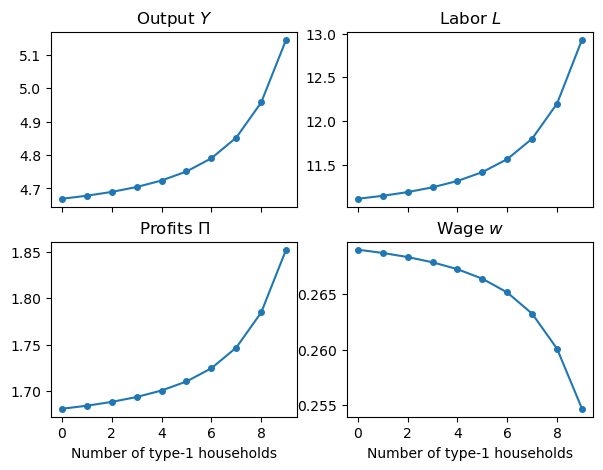

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(7, 5), sharex=True, sharey=False)
ax[0, 0].plot(N1_grid, Y_grid, marker="o", ms=4)
ax[0, 0].set_title("Output $Y$")

ax[0, 1].plot(N1_grid, L_grid, marker="o", ms=4)
ax[0, 1].set_title("Labor $L$")

ax[1, 0].plot(N1_grid, Pi_grid, marker="o", ms=4)
ax[1, 0].set_title(r"Profits $\Pi$")
ax[1, 0].set_xlabel("Number of type-1 households")

ax[1, 1].plot(N1_grid, w_grid, marker="o", ms=4)
ax[1, 1].set_title("Wage $w$")
ax[1, 1].set_xlabel("Number of type-1 households")

Text(0.5, 0, 'Number of type-1 households')

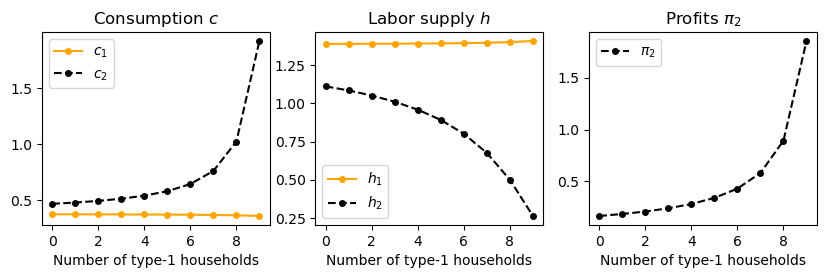

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(10, 2.5), sharex=True, sharey=False)

ax[0].plot(N1_grid, c1_grid, marker="o", ms=4, color="orange", label="$c_1$")
ax[0].plot(N1_grid, c2_grid, marker="o", ms=4, color="black", ls="--", label="$c_2$")
ax[0].set_title("Consumption $c$")
ax[0].legend()
ax[0].set_xlabel("Number of type-1 households")

ax[1].plot(N1_grid, h1_grid, marker="o", ms=4, color="orange", label="$h_1$")
ax[1].plot(N1_grid, h2_grid, marker="o", ms=4, color="black", ls="--", label="$h_2$")
ax[1].set_title("Labor supply $h$")
ax[1].legend()
ax[1].set_xlabel("Number of type-1 households")

ax[2].plot(
    N1_grid, pi2_grid, marker="o", ms=4, color="black", ls="--", label=r"$\pi_2$"
)
ax[2].set_title(r"Profits $\pi_2$")
ax[2].legend()
ax[2].set_xlabel("Number of type-1 households")

In [24]:
def foc_error(x, par: Parameters):
    """
    Compute errors in first-order conditions of the household problem
    for type 1 and type 2.

    (for bonus question)

    Parameters
    ----------
    x : array_like
        Candidate guess for labor supply (h1, h2).
    par : Parameters
        Model parameters.

    Returns
    -------
    numpy.ndarray
        Array containing the differences from the first-order conditions.
    """
    # Extract candidate guess for labor supply
    h1, h2 = x

    # Aggregate labor supply
    L = par.N1 * h1 + par.N2 * h2
    # wage from firm's FOC
    w = (1 - par.alpha) * par.z * L ** (-par.alpha)
    # Aggregate firm profits
    Pi = par.alpha * par.z * L ** (1 - par.alpha)

    # FOC for HH type 1
    diff1 = par.psi * h1 ** (1 / par.theta) / w - (w * h1) ** (-par.gamma)
    # Profits per capita for HH type 2
    pi2 = Pi / par.N2
    # FOC for HH type 2
    diff2 = par.psi * h2 ** (1 / par.theta) / w - (w * h2 + pi2) ** (-par.gamma)

    fx = np.array((diff1, diff2))

    return fx

In [25]:
from scipy.optimize import root

# Initial guess for labor supply (h1, h2)
x0 = np.array((0.5, 0.5))

# Find (h1, h2) that satisfy the FOCs
res = root(foc_error, x0=x0, args=(par,), method="hybr")

In [26]:
res

 message: The solution converged.
 success: True
  status: 1
     fun: [-4.195e-09  1.139e-09]
       x: [ 1.408e+00  2.629e-01]
  method: hybr
    nfev: 17
    fjac: [[-9.968e-01 -7.966e-02]
           [ 7.966e-02 -9.968e-01]]
       r: [-1.647e+01  1.386e+00 -2.662e+00]
     qtf: [ 2.347e-08 -1.499e-08]

In [27]:
import workshop06_ex2 as ex2

# Compute equilibrium using root-finding approach
eq = ex2.compute_equilibrium_root(par)

# Print equilibrium values using print function we defined earlier
ex2.print_equilibrium(eq)

Equilibrium:
  Households:
    Type 1 (N = 9):
      c1 = 0.35850
      h1 = 1.40768
    Type 2 (N = 1):
      c2 = 1.91950
      h2 = 0.26291
      pi2 = 1.85255
  Firms:
    Y = 5.14597
    L = 12.93206
    Pi = 1.85255
  Prices:
    w = 0.25467
  Market clearing:
    Labor market: -8.88178e-16
    Goods market: 8.88178e-16
    Profits: 0.00000e+00
